# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N° 4: Resolución del problema inverso

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pyDOE import lhs
from scipy.interpolate import LinearNDInterpolator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Xpde y Xbc

In [3]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [4]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [5]:
n_pde = 10_000
n_bc = 1_000
xy_pde_lhs = get_xy_pde_lhs([0, 1], [0, 1], n_pde)
X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
xy_bc_lhs = get_xy_bc_lhs([0, 1], [0, 1], n_bc)
X_bc = torch.tensor(xy_bc_lhs).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

### Muestreo ground-truth

In [6]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [7]:
mesh_size_list = [0.25, 0.5, 0.75]
n_mesh_size = 5

xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [8]:
def get_ds_data_mesh(pressure_ds, velocity_ds, mesh_size, n):
    x_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    y_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    x = np.linspace(x_bounds[0], x_bounds[1], n)
    y = np.linspace(y_bounds[0], y_bounds[1], n)
    xy = np.array([[x_i,y_i] for x_i in x for y_i in y])
    
    # Not all points are aligned. If a point is missing, we will find the nearest neightbor.
    u_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['u'][0])
    v_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['v'][0])
    p_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), pressure_ds['p'][0])
    
    labels = []
    for idx in range(len(xy)):
        data_idx = np.argwhere(np.logical_and(pressure_ds['x'][0] == xy[idx,0], pressure_ds['y'][0] == xy[idx,1]))
        if len(data_idx) > 0:
            data_idx = data_idx[0][0]
            assert pressure_ds['x'][0][data_idx] == velocity_ds['x'][0][data_idx]
            assert pressure_ds['y'][0][data_idx] == velocity_ds['y'][0][data_idx]
            labels.append([velocity_ds['u'][0][data_idx], velocity_ds['v'][0][data_idx], pressure_ds['p'][0][data_idx]])
        else:
            u_interpolated = u_interp_func(xy[idx,:])[0]
            v_interpolated = v_interp_func(xy[idx,:])[0]
            p_interpolated = p_interp_func(xy[idx,:])[0]
            labels.append([u_interpolated, v_interpolated, p_interpolated])
    return xy, np.array(labels)

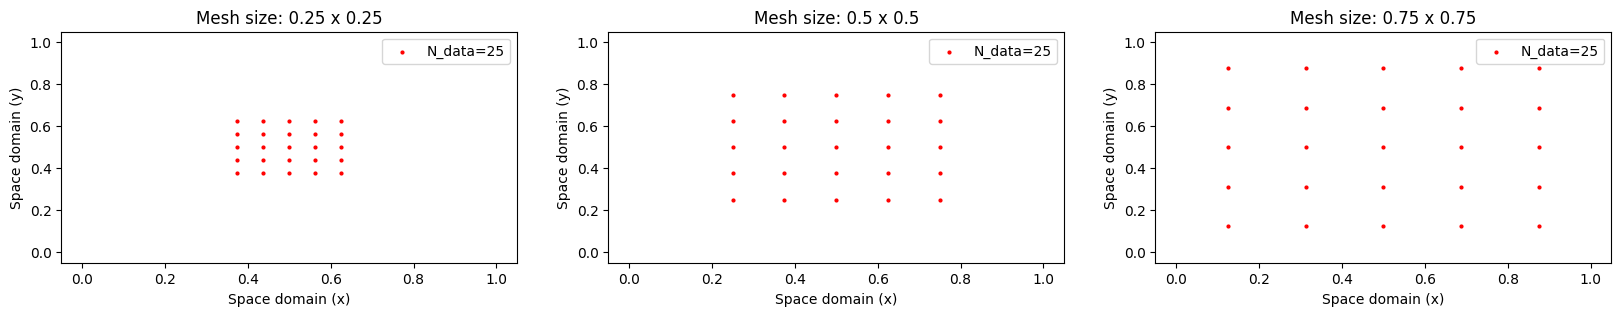

In [9]:
fig, ax = plt.subplots(1, len(mesh_size_list), figsize=(20, 3))
for i, mesh_size in enumerate(mesh_size_list):
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    ax[i].scatter(xy_data_mesh[:,0], xy_data_mesh[:,1], s=4, c='r', label=f'N_data={len(xy_data_mesh)}')
    ax[i].set_xlim([-0.05, 1.05])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].set_xlabel('Space domain (x)')
    ax[i].set_ylabel('Space domain (y)')
    ax[i].set_title(f"Mesh size: {mesh_size} x {mesh_size}")
    ax[i].legend()
plt.show()

### Modelo PINN

In [10]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        self.init_xavier()
        
    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_continuity, residue_momentum_x, residue_momentum_y

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]
        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        residue_u = u - u_bc
        residue_v = v # v = 0 on all border
        return residue_u, residue_v

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]
        residue_p = p # p = 0 on the origin
        return residue_p

### Entrenamiento inverso con datos limpios

In [11]:
# Shared model parameters
abs_smooth_fun = lambda x: x * torch.tanh(1e3 * x)
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}
epochs = 20_000

In [12]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, Re):
    model.Reynolds = abs_smooth_fun(Re)
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = (loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y) / 3
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p * 100
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)
    
    return loss_pde, loss_bc, loss_data

In [34]:
print("Reynolds parameter inverse problem with clean data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.rand(1).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1}])

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {abs_smooth_fun(reynolds).item()}")
    print(f"Reynolds value: {abs_smooth_fun(reynolds).item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Grafica sobre x=0.5
    mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
    xy_data_x05 = xy_data_all[mask_x05]
    labels_data_x05 = labels_data_all[mask_x05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_x05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('y')
        ax[i].set_title(f"{title} (x=0.5)")
        ax[i].legend()
    plt.show()

    # Grafica sobre y=0.5
    mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
    xy_data_y05 = xy_data_all[mask_y05]
    labels_data_y05 = labels_data_all[mask_y05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_y05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('x')
        ax[i].set_title(f"{title} (y=0.5)")
        ax[i].legend()
    plt.show()

Reynolds parameter inverse problem with clean data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3059e-01, PDE: 1.4986e-02, BC: 1.1122e-01, Data: 4.3844e-03 - Reynolds: 94.6339111328125
Epoch 2000/20000 - Loss Overall: 8.1289e-02, PDE: 9.5917e-03, BC: 6.9857e-02, Data: 1.8401e-03 - Reynolds: 169.91064453125
Epoch 3000/20000 - Loss Overall: 6.4777e-02, PDE: 1.0547e-02, BC: 5.3108e-02, Data: 1.1220e-03 - Reynolds: 250.94094848632812
Epoch 4000/20000 - Loss Overall: 4.9640e-02, PDE: 9.5618e-03, BC: 3.9380e-02, Data: 6.9802e-04 - Reynolds: 325.28912353515625
Epoch 5000/20000 - Loss Overall: 4.1892e-02, PDE: 8.6719e-03, BC: 3.2703e-02, Data: 5.1715e-04 - Reynolds: 403.4864501953125
Epoch 6000/20000 - Loss Overall: 3.5224e-02, PDE: 8.1680e-03, BC: 2.6695e-02, Data: 3.6028e-04 - Reynolds: 490.86358642578125
Epoch 7000/20000 - Loss Overall: 3.0740e-02, PDE: 7.3499e-03, BC: 2.3080e-02, Data: 3.0999e-04 - Reynolds: 592.0830688476562
Epoch 8000/20000 - Loss Overall: 3.0804e-02, PDE: 7.0195e-03, BC: 2.3544e-02, Data: 2.4014e-04 - Reynolds: 709.5288696289062


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.4497e-01, PDE: 1.5786e-02, BC: 1.2368e-01, Data: 5.5074e-03 - Reynolds: 67.13082885742188
Epoch 2000/20000 - Loss Overall: 1.1757e-01, PDE: 1.3775e-02, BC: 1.0106e-01, Data: 2.7281e-03 - Reynolds: 114.31157684326172
Epoch 3000/20000 - Loss Overall: 7.0213e-02, PDE: 1.2383e-02, BC: 5.6396e-02, Data: 1.4348e-03 - Reynolds: 156.91848754882812
Epoch 4000/20000 - Loss Overall: 7.2604e-02, PDE: 1.1693e-02, BC: 6.0170e-02, Data: 7.4118e-04 - Reynolds: 198.5251922607422
Epoch 5000/20000 - Loss Overall: 4.7700e-02, PDE: 1.0482e-02, BC: 3.6563e-02, Data: 6.5541e-04 - Reynolds: 244.46493530273438
Epoch 6000/20000 - Loss Overall: 3.8545e-02, PDE: 8.8672e-03, BC: 2.9171e-02, Data: 5.0660e-04 - Reynolds: 293.56353759765625
Epoch 7000/20000 - Loss Overall: 3.8049e-02, PDE: 7.5539e-03, BC: 3.0047e-02, Data: 4.4778e-04 - Reynolds: 346.8485107421875
Epoch 8000/20000 - Loss Overall: 3.0918e-02, PDE: 7.5876e-03, BC: 2.2849e-02, Data: 4.8159e-04 - Reynolds: 404.6187744140

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.5889e-01, PDE: 2.1021e-02, BC: 1.3228e-01, Data: 5.5894e-03 - Reynolds: 36.982662200927734
Epoch 2000/20000 - Loss Overall: 9.3926e-02, PDE: 1.4463e-02, BC: 7.7748e-02, Data: 1.7153e-03 - Reynolds: 55.51778793334961
Epoch 3000/20000 - Loss Overall: 7.1007e-02, PDE: 1.1219e-02, BC: 5.9108e-02, Data: 6.7981e-04 - Reynolds: 70.03773498535156
Epoch 4000/20000 - Loss Overall: 5.4863e-02, PDE: 9.6459e-03, BC: 4.4752e-02, Data: 4.6491e-04 - Reynolds: 82.50106048583984
Epoch 5000/20000 - Loss Overall: 3.7726e-02, PDE: 6.5637e-03, BC: 3.0960e-02, Data: 2.0248e-04 - Reynolds: 94.40902709960938
Epoch 6000/20000 - Loss Overall: 2.9762e-02, PDE: 5.0979e-03, BC: 2.4544e-02, Data: 1.2019e-04 - Reynolds: 108.41265869140625
Epoch 7000/20000 - Loss Overall: 2.7577e-02, PDE: 3.4739e-03, BC: 2.4013e-02, Data: 8.9824e-05 - Reynolds: 121.84196472167969
Epoch 8000/20000 - Loss Overall: 2.1950e-02, PDE: 3.0338e-03, BC: 1.8813e-02, Data: 1.0332e-04 - Reynolds: 133.41354370117

### Entrenamiento inverso con datos con ruido

In [35]:
# Noise percentage
omega = 0.01

In [38]:
print("Reynolds parameter inverse problem with noisy data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.rand(1).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1}])

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    labels_data_mesh = labels_data_mesh + \
        omega * np.max(labels_data_mesh, axis=0)[np.newaxis,:] * np.random.normal(size=(labels_data_mesh.shape))
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {abs_smooth_fun(reynolds).item()}")
    print(f"Reynolds value: {abs_smooth_fun(reynolds).item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Grafica sobre x=0.5
    mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
    xy_data_x05 = xy_data_all[mask_x05]
    labels_data_x05 = labels_data_all[mask_x05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_x05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('y')
        ax[i].set_title(f"{title} (x=0.5)")
        ax[i].legend()
    plt.show()

    # Grafica sobre y=0.5
    mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
    xy_data_y05 = xy_data_all[mask_y05]
    labels_data_y05 = labels_data_all[mask_y05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_y05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('x')
        ax[i].set_title(f"{title} (y=0.5)")
        ax[i].legend()
    plt.show()

Reynolds parameter inverse problem with noisy data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.7729e-01, PDE: 2.0721e-02, BC: 1.5468e-01, Data: 1.8898e-03 - Reynolds: 10.434347152709961
Epoch 2000/20000 - Loss Overall: 1.2938e-01, PDE: 1.9272e-02, BC: 1.0901e-01, Data: 1.0987e-03 - Reynolds: 15.481565475463867
Epoch 3000/20000 - Loss Overall: 9.3794e-02, PDE: 1.5535e-02, BC: 7.7280e-02, Data: 9.7947e-04 - Reynolds: 22.147201538085938
Epoch 4000/20000 - Loss Overall: 6.4251e-02, PDE: 1.1617e-02, BC: 5.2125e-02, Data: 5.0930e-04 - Reynolds: 28.212467193603516
Epoch 5000/20000 - Loss Overall: 4.9286e-02, PDE: 9.2606e-03, BC: 3.9636e-02, Data: 3.9022e-04 - Reynolds: 34.20429611206055
Epoch 6000/20000 - Loss Overall: 4.1645e-02, PDE: 6.6117e-03, BC: 3.4789e-02, Data: 2.4427e-04 - Reynolds: 40.81296157836914
Epoch 7000/20000 - Loss Overall: 3.2993e-02, PDE: 7.6872e-03, BC: 2.5107e-02, Data: 1.9865e-04 - Reynolds: 47.97142791748047
Epoch 8000/20000 - Loss Overall: 2.7352e-02, PDE: 4.5941e-03, BC: 2.2618e-02, Data: 1.3924e-04 - Reynolds: 55.51871490478

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3150e-01, PDE: 2.0021e-02, BC: 1.0878e-01, Data: 2.7025e-03 - Reynolds: 52.44612121582031
Epoch 2000/20000 - Loss Overall: 7.9900e-02, PDE: 1.4783e-02, BC: 6.3850e-02, Data: 1.2669e-03 - Reynolds: 88.81922912597656
Epoch 3000/20000 - Loss Overall: 5.8044e-02, PDE: 1.3058e-02, BC: 4.4329e-02, Data: 6.5685e-04 - Reynolds: 121.39179992675781
Epoch 4000/20000 - Loss Overall: 4.5510e-02, PDE: 1.1652e-02, BC: 3.3468e-02, Data: 3.8983e-04 - Reynolds: 151.96107482910156
Epoch 5000/20000 - Loss Overall: 3.6430e-02, PDE: 9.6061e-03, BC: 2.6451e-02, Data: 3.7247e-04 - Reynolds: 178.58197021484375
Epoch 6000/20000 - Loss Overall: 2.8536e-02, PDE: 7.1106e-03, BC: 2.1164e-02, Data: 2.6154e-04 - Reynolds: 199.24729919433594
Epoch 7000/20000 - Loss Overall: 4.1591e-02, PDE: 8.1214e-03, BC: 3.3090e-02, Data: 3.8025e-04 - Reynolds: 216.42547607421875
Epoch 8000/20000 - Loss Overall: 2.0139e-02, PDE: 4.7729e-03, BC: 1.5152e-02, Data: 2.1406e-04 - Reynolds: 230.359451293

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3185e-01, PDE: 1.4910e-02, BC: 1.0993e-01, Data: 7.0112e-03 - Reynolds: 77.99290466308594
Epoch 2000/20000 - Loss Overall: 9.3722e-02, PDE: 1.3332e-02, BC: 7.5709e-02, Data: 4.6807e-03 - Reynolds: 122.2645263671875
Epoch 3000/20000 - Loss Overall: 7.0461e-02, PDE: 1.3599e-02, BC: 5.2908e-02, Data: 3.9534e-03 - Reynolds: 169.52142333984375
Epoch 4000/20000 - Loss Overall: 6.2447e-02, PDE: 1.4137e-02, BC: 4.5826e-02, Data: 2.4848e-03 - Reynolds: 225.6462860107422
Epoch 5000/20000 - Loss Overall: 5.1180e-02, PDE: 1.3998e-02, BC: 3.5197e-02, Data: 1.9854e-03 - Reynolds: 292.1361389160156
Epoch 6000/20000 - Loss Overall: 4.0118e-02, PDE: 9.9495e-03, BC: 2.8720e-02, Data: 1.4488e-03 - Reynolds: 369.08514404296875
Epoch 7000/20000 - Loss Overall: 4.0620e-02, PDE: 8.5621e-03, BC: 3.0784e-02, Data: 1.2736e-03 - Reynolds: 456.4134521484375
Epoch 8000/20000 - Loss Overall: 3.3674e-02, PDE: 8.0732e-03, BC: 2.4402e-02, Data: 1.1991e-03 - Reynolds: 552.450500488281

### Conclusiones

- De lo observado, en determinados entrenamientos el valor obtenido del número de Reynolds se acercó al valor esperado. Se observa que el entrenamiento es muy sensible a mínimos locales y a las condiciones iniciales de los parámetros de la red, lo que impide que el modelo converga a valores estables.
- Se estima que con una red mas grande y con mayor cantidad de epochs el valor del número de Reynolds se acercaría establemente al valor real.
- Respecto a la distribución espacial de las muestras, se observa que si se toman valores mas separados, el entrenamiento converge más facilmente y a valores de Reynolds mas cercanos al esperado.
- Respecto a la presencia de ruido, se observa que los valores obtenidos poseen mayor error y que la convergencia de la red a los valores de Reynolds esperados es de mayor dificultad.